In [1]:
# Loading the necessary libraries:
library(tidyverse)
library(dplyr)
library(tidymodels)
install.packages("themis")
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Introduction

Pulsars emit two beams of light in opposite directions. Although the beam's light is steady, pulsars appear to flicker because they rotate.  As the pulsar rotates, the light beam may sweep over the Earth, swinging in and out of view, creating the impression that the pulsar is blinking to an astronomer.

Because pulsars are important space objects that allow scientists to study extreme states of matter and cosmic events, it would be great if we had a system to predict whether a particular space object is a pulsar. Therefore, can we use the information from the data set to create a model that can predict a pulsar star?

The data set contains nine columns. Eight continuous variables and one class variable. The first four variables are statistics derived from a pulsar’s integrated pulse profile, which are unique to a pulsar, whereas the latter four are derived from the DM-SNR (Dispersion Measure of Signal Noise Ratio).



In [2]:
# Reading and tidying the dataset.
pulsar_data <- read_csv("data/HTRU_2.csv", col_names = FALSE) |> # Read the CSV file
    # Add column names:
    rename(mean_intp = X1, 
           std_dev_intp = X2, 
           xs_kurtosis_intp = X3, 
           skewness_intp = X4, 
           mean_dmsnr = X5, 
           std_dev_dmsnr = X6, 
           xs_kurtosis_dmsnr = X7, 
           skewness_dmsnr = X8, 
           class = X9) |>
    tibble::rowid_to_column('id') |> # Adds an id to each individual pulsar star candidate.
    mutate(class = as_factor(class), id = as_factor(id)) |> # Change class from dbl to factor (category) as these are categorial variables.
    select(id, class, everything()) |> # Reorder class as the first column in the table for organization purposes.
    mutate(class = case_when(class == 0 ~ "non_pulsar",
                            class == 1 ~ "pulsar")) # Clarify the classes.

options(repr.matrix.max.rows = 10) # Shows a maximum of 10 rows to reduce clutter when calling the dataset.
pulsar_data # display the dataframe as a table


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,class,mean_intp,std_dev_intp,xs_kurtosis_intp,skewness_intp,mean_dmsnr,std_dev_dmsnr,xs_kurtosis_dmsnr,skewness_dmsnr
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,non_pulsar,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222
2,non_pulsar,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358
3,non_pulsar,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191
4,non_pulsar,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366
5,non_pulsar,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
17894,non_pulsar,136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022
17895,non_pulsar,122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092
17896,non_pulsar,119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173


In [3]:
# Creating the training dataset:

set.seed(1234)

pulsar_data_split <- pulsar_data |> initial_split(prop = 0.75, strata = class)
pulsar_data_training <- pulsar_data_split |> training()

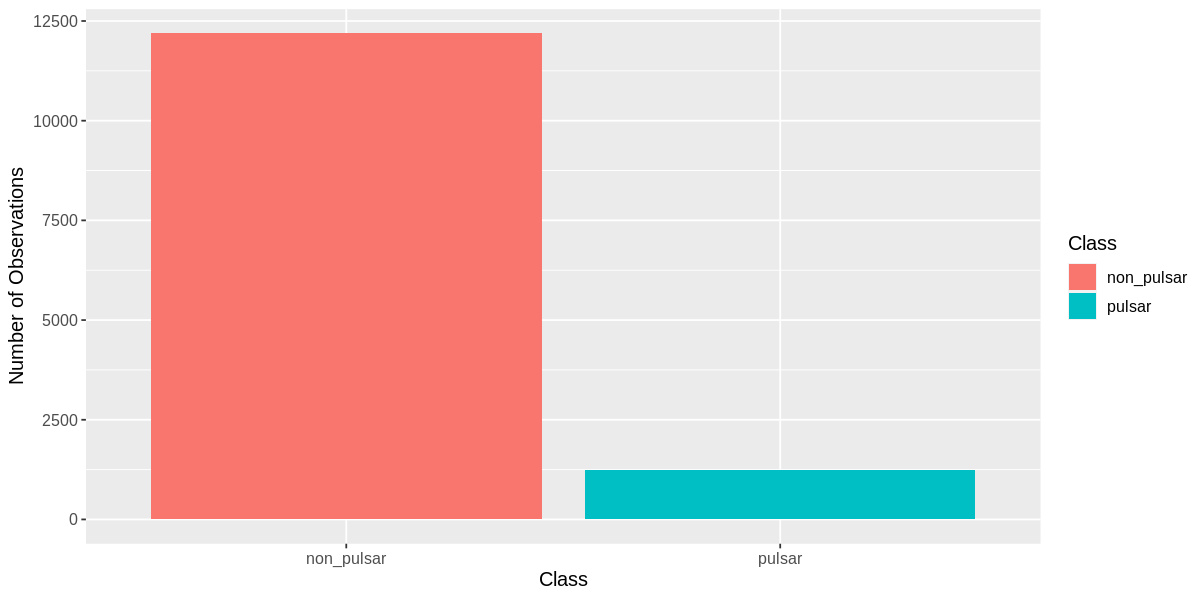

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)
class_distribution_plot <- pulsar_data_training |>
                           ggplot(aes(x = class, fill = class)) +
                           geom_bar() + labs(x = "Class", y = "Number of Observations", fill = "Class") +
                           theme(text = element_text(size = 12))
class_distribution_plot



Here we can see that the distribution between the 2 classes are imbalanced with the majority being non-pulsars. Before we head into creating the classification model, we'll have to balance the data first. 

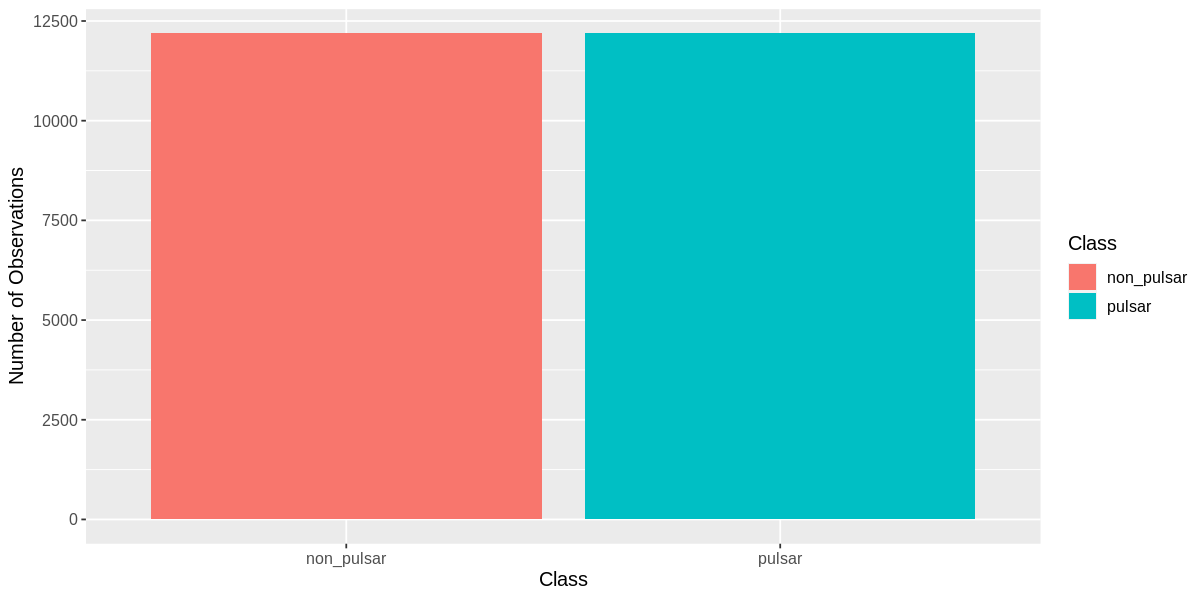

In [17]:
#Balancing the classes

ups_recipe <- recipe(class ~ ., data = pulsar_data_training) |>
  step_upsample(class, over_ratio = 1, skip = FALSE) |>
  prep()


upsampled_pulsar <- bake(ups_recipe, pulsar_data_training)

upsampled_plot <- upsampled_pulsar |> 
                  ggplot(aes(x = class, fill = class)) +
                           geom_bar() + labs(x = "Class", y = "Number of Observations", fill = "Class") +
                           theme(text = element_text(size = 12))

upsampled_plot

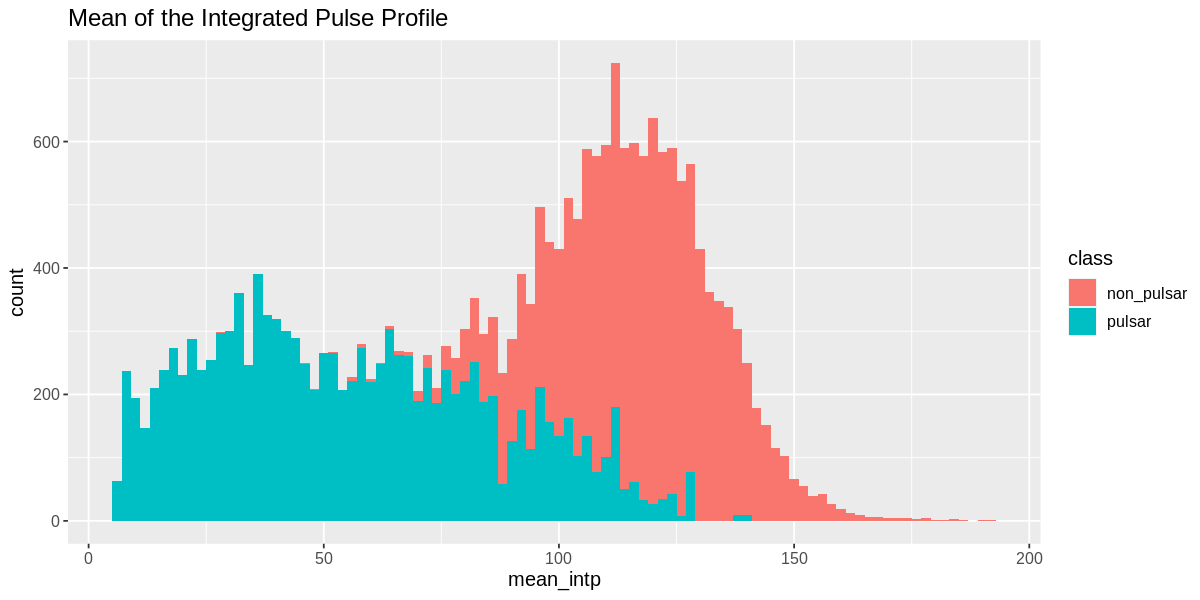

In [18]:

pulsar_data_plot_mean_intp <- upsampled_pulsar |> 
                             ggplot(aes(x = mean_intp, fill = class)) +
                             geom_histogram(binwidth = 2) +
                             theme(text = element_text(size = 12)) +
                             ggtitle("Mean of the Integrated Pulse Profile")

pulsar_data_plot_mean_intp

Here we can see a certain pattern between the classes and the mean of the integrated profiles. The plot shows that non-pulsars generally have a higher mean compared to pulsars.

In [19]:
#summary tables

pulsar_data_training_summary <- upsampled_pulsar |> 
                                group_by(class) |>  
                                summarize(count = n())
pulsar_data_training_summary

pulsar_data_training_means_intp <- upsampled_pulsar |> 
                              group_by(class) |> 
                              summarize(mean_intp_2 = mean(mean_intp))
pulsar_data_training_means_intp


class,count
<fct>,<int>
non_pulsar,12188
pulsar,12188


class,mean_intp_2
<fct>,<dbl>
non_pulsar,116.55899
pulsar,55.74215


We expect to find that we should be able to get a prediction of whether or not a candidate is a pulsar or not. This will be done by using all of the numerical variables into the recipe.

Using this prediction, we would be able to predict if newly discovered stars are pulsars, given that the data we collect is part of our prediction model. We will take 75% of the above data frame to train our model while using the other 25% to test our model.

This could lead to further questions such as:

- What’s the minimum/maximum DM-SNR curve for a certain star for it to no longer be considered a pulsar?
- What is the average skewness of a pulsar? And for non-pulsars?